In [77]:
import numpy as np
import pandas as pd

import xgboost

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import RobustScaler

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [19]:
import os
os.getcwd()

'/home/kacper/Repos/wb2021/proj2/DNN'

In [103]:
train_icu = pd.read_csv("../data/splitted/icu_train.csv").iloc[:, 1:]
test_icu = pd.read_csv("../data/splitted/icu_test.csv").iloc[:, 1:]

rs_icu = RobustScaler()

X_train_icu = np.array(train_icu.iloc[:, :-1])
X_train_icu_scaled = rs_icu.fit_transform(np.array(train_icu.iloc[:, :-1]))
y_train_icu = np.array(train_icu.iloc[:, -1])

X_test_icu = np.array(test_icu.iloc[:, :-1])                
X_test_icu_scaled = rs_icu.transform(np.array(test_icu.iloc[:, :-1]))
y_test_icu = np.array(test_icu.iloc[:, -1])

In [104]:
train_exp = pd.read_csv("../data/splitted/expired_train.csv").iloc[:, 1:]
test_exp = pd.read_csv("../data/splitted/expired_test.csv").iloc[:, 1:]

rs_exp = RobustScaler()

X_train_exp = np.array(train_exp.iloc[:, :-1])
X_train_exp_scaled = rs_exp.fit_transform(np.array(train_exp.iloc[:, :-1]))

y_train_exp = np.array(train_exp.iloc[:, -1])

X_test_exp = np.array(test_exp.iloc[:, :-1])
X_test_exp_scaled = rs_exp.transform(np.array(test_exp.iloc[:, :-1]))

y_test_exp = np.array(test_exp.iloc[:, -1])

In [21]:
def make_article_layer(neurons, **kwargs):
    return Dense(neurons, activation="relu", kernel_initializer="he_normal", kernel_regularizer="l2", **kwargs)

def make_article_model(loss="mean_squared_error", input_shape=(5,)):
    # The DNN model used five hidden layers with 6, 8, 16, 8, 4 neurons respectively.
    model = Sequential()
    model.add(make_article_layer(6, input_shape=input_shape))
    model.add(make_article_layer(8))
    model.add(make_article_layer(16))
    model.add(make_article_layer(8))
    model.add(make_article_layer(4))
    # [...] the sigmoid activation function for the output layer, and the “he_normal” normalization scheme were applied. 
    model.add(Dense(1, activation="sigmoid", kernel_initializer="he_normal", kernel_regularizer="l2"))
    model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
    return model

def make_modified(input_shape=(5,)):
    return make_article_model(input_shape=input_shape, loss="binary_crossentropy")

def make_basic(input_shape=(5,)):
    wider = Sequential()
    wider.add(Dense(32, activation="relu", input_shape=input_shape))
    wider.add(Dense(32, activation="relu"))
    wider.add(Dense(1, activation="sigmoid"))
    wider.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return wider

In [22]:
def calc_roc_keras(model, X_test, y_test): 
    y_pred_keras = model.predict(X_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
    return fpr_keras, tpr_keras

In [67]:
def plot_rocs(rates: [(np.array, np.array)], names):
    plotted_aucs = []
    for fpr, tpr in rates:
        plt.plot(fpr, tpr)
        plotted_aucs.append(auc(fpr, tpr))
    plt.legend([f"{name} AUC: {area:.3f}" for name, area in zip(names, plotted_aucs)], loc="lower right")
    plt.plot([0,1], [0,1], "r--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")

In [24]:
def make_and_fit_keras(constructor, X_train, y_train, icu=True):
    if icu:
        input_shape=(5,)
    else:
        input_shape=(6,)
    model = constructor(input_shape=input_shape)
    model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)
    return model

In [105]:
exp_article_model = make_and_fit_keras(make_article_model, X_train_exp_scaled, y_train_exp, icu=False)
exp_basic_model = make_and_fit_keras(make_basic, X_train_exp_scaled, y_train_exp, icu=False)
exp_modified_model = make_and_fit_keras(make_modified, X_train_exp_scaled, y_train_exp, icu=False)

In [52]:
exp_xgb = xgboost.XGBClassifier()
exp_xgb.load_model('../models/xgb_expired.model')

Loading a native XGBoost model with Scikit-Learn interface.


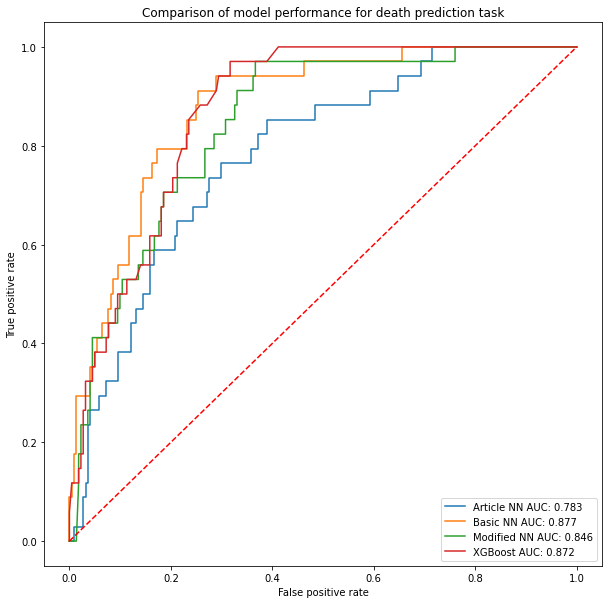

In [106]:
plt.figure(figsize=(10,10))
plot_rocs(
    [
        calc_roc_keras(exp_article_model, X_test_exp_scaled, y_test_exp),
        calc_roc_keras(exp_basic_model, X_test_exp_scaled, y_test_exp),
        calc_roc_keras(exp_modified_model, X_test_exp_scaled, y_test_exp),
        roc_curve(y_test_exp, exp_xgb.predict_proba(X_test_exp)[:,1])[0:2]
    ],
    ["Article NN", "Basic NN", "Modified NN", "XGBoost"]
)
plt.title("Comparison of model performance for death prediction task")
plt.show()


In [99]:
icu_article_model = make_and_fit_keras(make_article_model, X_train_icu_scaled, y_train_icu)
icu_basic_model = make_and_fit_keras(make_basic, X_train_icu_scaled, y_train_icu)
icu_modified_model = make_and_fit_keras(make_modified, X_train_icu_scaled, y_train_icu)

In [75]:
icu_xgb = xgboost.XGBClassifier()
icu_xgb.load_model('../models/xgb_icu.model')

Loading a native XGBoost model with Scikit-Learn interface.


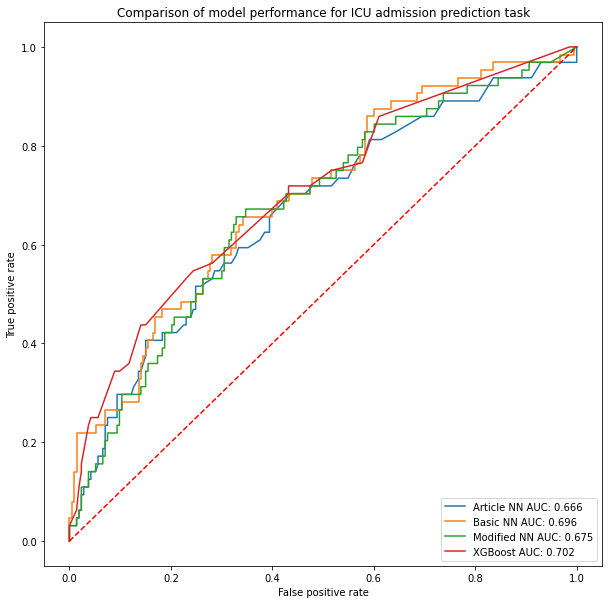

In [100]:
plt.figure(figsize=(10,10))
plot_rocs(
    [
        calc_roc_keras(icu_article_model, X_test_icu_scaled, y_test_icu),
        calc_roc_keras(icu_basic_model, X_test_icu_scaled, y_test_icu),
        calc_roc_keras(icu_modified_model, X_test_icu_scaled, y_test_icu),
        roc_curve(y_test_icu, icu_xgb.predict_proba(X_test_icu)[:,1])[0:2]
    ],
    ["Article NN", "Basic NN", "Modified NN", "XGBoost"]
)
plt.title("Comparison of model performance for ICU admission prediction task")
plt.show()
